In [5]:
import numpy as np
import pandas as pd
import cvxpy as cp

import matplotlib
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
import helper.entsoe_wrapper as entsoe
import helper.intensity as intensity

In [6]:
from usecase.solve import offline_solver
from usecase.dataloader import expand_gateway

In [3]:
start=pd.Timestamp('2022-01-01',tz='utc')
end=pd.Timestamp('2022-12-31',tz='utc')

## 1. Loading Data

In [16]:
country_list   = ["DE","DE", "PL", "ES", "AT", "BE", "NL", "FR", "IT", "SE"]
price_all_loc  = []
carbon_all_loc = []
water_all_loc  = []

for country in country_list:
    print(country)
    df             = entsoe.get_price_data(country, start, end)
    price_array    = df.iloc[:457,0]
    price_all_loc += [price_array]
    
    df              = intensity.get_average_intensity(country, start, end, water=False)
    carbon_array    = df.to_numpy()[:457]
    carbon_all_loc += [carbon_array]
    
    df             = intensity.get_complete_WUE(country, start, end)
    water_array    = df.to_numpy()[:457]
    water_all_loc += [water_array]    

price_all_loc  = np.stack(price_all_loc,  axis=0)
carbon_all_loc = np.stack(carbon_all_loc, axis=0)
water_all_loc  = np.stack(water_all_loc,  axis=0)


wkld_csv_file  = "usecase/AI_workload.csv"
df             = pd.read_csv(wkld_csv_file)
workload_trace = df["Power (Watt)"].to_numpy()
workload_trace = workload_trace/2708.0*10
workload_trace = np.repeat(workload_trace.reshape([1,-1])/10, 10, axis=0)

DE
DE
PL
ES
AT
BE
NL
FR
IT
SE


In [17]:
water_all_loc.shape

(10, 457)

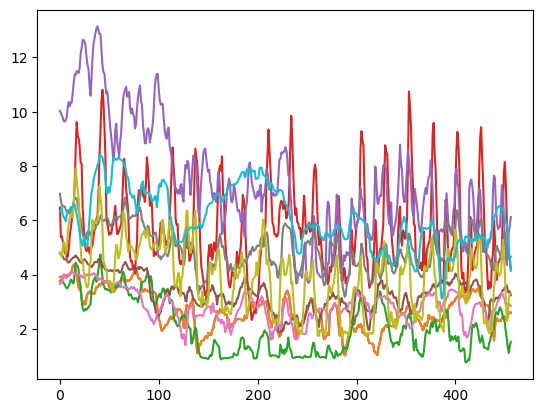

In [18]:
plt.plot(water_all_loc.T)

### 1.1 Preprocess Data

In [7]:
si        = 0
ei        = 457
num_ins   = ei - si

price_all_loc  = price_all_loc[:, si:ei]
carbon_all_loc = carbon_all_loc[:, si:ei]
water_all_loc  = water_all_loc[:, si:ei]
workload_trace = workload_trace[:, si:ei]

price_all_loc  = expand_gateway(price_all_loc)
carbon_all_loc = expand_gateway(carbon_all_loc)
water_all_loc  = expand_gateway(water_all_loc)

print(price_all_loc.shape)
print(carbon_all_loc.shape)
print(water_all_loc.shape)
print(workload_trace.shape)

mask         = np.ones([10,10])
mask_array   = np.repeat(mask.reshape([-1,1]), num_ins , axis=1)

(100, 457)
(100, 457)
(100, 457)
(10, 457)


## 2. Start Experiment

In [9]:
l_1 = 60       # mu_water for the water consumption weight
l_2 = 1500     # mu_carbon for carbon emission weight

### 2.1 Closest Connection

In [10]:
mask_ones         = np.eye(10)
mask_ones_array   = np.repeat(mask.reshape([-1,1]), num_ins , axis=1)

optimal_cost, action_mask  = offline_solver(price_all_loc, water_all_loc, carbon_all_loc, workload_trace, mask_ones_array, num_ins, verbose=True, l_1 = l_1, l_2 = l_2)
print("Closest Connection: ", optimal_cost)

data_dict_cc = {"Name": "Closest Connection",
                "Total_Cost": optimal_cost,
                "Action": action_mask}
print(optimal_cost)
print(action_mask.shape)

Start Solving...
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 13 12:08:35 PM: Your problem has 45700 variables, 54840 constraints, and 0 parameters.
(CVXPY) Jan 13 12:08:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 13 12:08:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 13 12:08:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 13 12:08:37 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 13 12:08:38 PM: Compiling problem (t

In [7]:
with open('output/result_closest_connect.pkl', 'wb') as handle:
    pickle.dump(data_dict_cc, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 2.2 Equitable (Ours)

In [11]:
optimal_cost, action_mask  = offline_solver(price_all_loc, water_all_loc, carbon_all_loc, workload_trace, mask_array, num_ins, verbose=True, l_1 = l_1, l_2 = l_2, f_type = "MAX")
print("All Connection: ", optimal_cost)

data_dict_eq = {"Name": "Equitable",
                "Total_Cost": optimal_cost,
                "Action": action_mask}
print(optimal_cost)
print(action_mask.shape)

Start Solving...
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 13 12:11:20 PM: Your problem has 45700 variables, 54840 constraints, and 0 parameters.
(CVXPY) Jan 13 12:11:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 13 12:11:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 13 12:11:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 13 12:11:21 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 13 12:11:22 PM: Compiling problem (t

In [9]:
with open('output/result_equitable.pkl', 'wb') as handle:
    pickle.dump(data_dict_eq, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 2.3 Min Price

In [10]:
optimal_cost, action_mask  = offline_solver(price_all_loc, water_all_loc, carbon_all_loc, workload_trace, mask_array, num_ins, verbose=True, l_1 = 0, l_2 = 0, f_type = "AVG")
print("All Connection: ", optimal_cost)

data_dict_mp = {"Name": "Min Price",
                "Total_Cost": optimal_cost,
                "Action": action_mask}
print(optimal_cost)
print(action_mask.shape)

Start Solving...
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jun 26 06:45:20 PM: Your problem has 45700 variables, 54840 constraints, and 0 parameters.
(CVXPY) Jun 26 06:45:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 26 06:45:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 26 06:45:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 26 06:45:23 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 26 06:45:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

In [11]:
with open('output/result_min_price.pkl', 'wb') as handle:
    pickle.dump(data_dict_mp, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 2.4 Price plus Carbon

In [12]:
# Minimize the average price and carbon
optimal_cost, action_mask  = offline_solver(price_all_loc, water_all_loc, carbon_all_loc, workload_trace, mask_array, num_ins, verbose=True, l_1 = 0, l_2 = l_2*4, f_type = "AVG")
print("All Connection: ", optimal_cost)

data_dict_pc = {"Name": "Price and Carbon",
                "Total_Cost": optimal_cost,
                "Action": action_mask}
print(optimal_cost)
print(action_mask.shape)

Start Solving...
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jun 26 06:46:59 PM: Your problem has 45700 variables, 54840 constraints, and 0 parameters.
(CVXPY) Jun 26 06:47:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 26 06:47:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 26 06:47:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 26 06:47:02 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 26 06:47:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

In [13]:
with open('output/result_price_carbon.pkl', 'wb') as handle:
    pickle.dump(data_dict_pc, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 2.5 Total Cost Minimize

In [14]:
# Minimize the average of total cost (price + water + carbon)
optimal_cost, action_mask  = offline_solver(price_all_loc, water_all_loc, carbon_all_loc, workload_trace, mask_array, num_ins, verbose=True, l_1 = l_1*5, l_2 = l_2*2, f_type = "AVG")
print("All Connection: ", optimal_cost)

data_dict_tc = {"Name": "Total Cost",
                "Total_Cost": deepcopy(optimal_cost),
                "Action": action_mask}
print(optimal_cost)
print(action_mask.shape)

Start Solving...
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jun 26 06:48:39 PM: Your problem has 45700 variables, 54840 constraints, and 0 parameters.
(CVXPY) Jun 26 06:48:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 26 06:48:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 26 06:48:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 26 06:48:42 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 26 06:48:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

In [15]:
with open('output/result_total_cost.pkl', 'wb') as handle:
    pickle.dump(data_dict_tc, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 2.6 Pure Water

In [16]:
# Only minimize the water consumption
optimal_cost, action_mask  = offline_solver(price_all_loc, water_all_loc, carbon_all_loc, workload_trace, mask_array, num_ins, verbose=True, l_0 = 0, l_1 = l_1, l_2 = 0, f_type = "AVG")
print("All Connection: ", optimal_cost)

data_dict_pw = {"Name": "Pure Water",
                "Total_Cost": optimal_cost,
                "Action": action_mask}
print(optimal_cost)
print(action_mask.shape)

Start Solving...
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jun 26 06:50:19 PM: Your problem has 45700 variables, 54840 constraints, and 0 parameters.
(CVXPY) Jun 26 06:50:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 26 06:50:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 26 06:50:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 26 06:50:22 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 26 06:50:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

In [17]:
with open('output/result_pure_water.pkl', 'wb') as handle:
    pickle.dump(data_dict_pw, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 2.7 Pure Carbon

In [18]:
# Only minimize the carbon emission
optimal_cost, action_mask  = offline_solver(price_all_loc, water_all_loc, carbon_all_loc, workload_trace, mask_array, num_ins, verbose=True, l_0 = 0, l_1 = 0, l_2 = l_2, f_type = "AVG")
print("All Connection: ", optimal_cost)

data_dict_pc = {"Name": "Pure Carbon",
                "Total_Cost": optimal_cost,
                "Action": action_mask}
print(optimal_cost)
print(action_mask.shape)

Start Solving...
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jun 26 06:51:59 PM: Your problem has 45700 variables, 54840 constraints, and 0 parameters.
(CVXPY) Jun 26 06:52:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 26 06:52:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 26 06:52:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 26 06:52:03 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jun 26 06:52:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

In [19]:
with open('output/result_pure_carbon_2.pkl', 'wb') as handle:
    pickle.dump(data_dict_pc, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 3. Final Evaluation

In [20]:
file_list = ["result_closest_connect.pkl", "result_equitable.pkl", "result_min_price.pkl", "result_price_carbon.pkl", "result_total_cost.pkl"]

for path in file_list:
    with open('output/' + path, "rb") as handle:
        current_dict = pickle.load(handle)
                                   
    optimal_cost  = current_dict["Total_Cost"]
    action_mask   = current_dict["Action"].reshape([10,10,-1])

    price_res   = evaluate_single(action_mask, price_all_loc)
    water_res   = evaluate_single(action_mask, water_all_loc)
    carbon_res  = evaluate_single(action_mask, carbon_all_loc)

    print("-------")
    print(current_dict["Name"])
    print("-------")
    
    # Mean and max of electricity price
    print(np.mean(price_res))
    print(np.max(price_res))
    
    # Mean and max of water consumption
    print(np.mean(water_res))
    print(np.max(water_res))
    
    # Mean and max of carbon emission
    print(np.mean(carbon_res))
    print(np.max(carbon_res))

    print("*"*50)

-------
Closest Connection
-------
33669.45105842025
59253.78319315321
1432.792210790843
1818.734618500509
104.91162881039315
118.5618431881312
**************************************************
-------
Equitable
-------
33669.45105842025
59253.78319315321
1432.792210790843
1818.734618500509
104.91162881039315
118.5618431881312
**************************************************
-------
Min Price
-------
29169.8606287178
42327.51158875257
1525.069250911699
2607.499995942185
108.714105315913
182.1356032921319
**************************************************
-------
Price and Carbon
-------
31272.43697395047
70779.11182583393
1467.7833974742239
2669.609162962292
100.21896130273169
175.56486541730902
**************************************************
-------
Total Cost
-------
31473.60117948522
64842.2236301698
1429.4631562176683
2566.60363884651
101.13308465168961
179.172750240521
**************************************************
